In [1]:
import dataset
import matplotlib.pyplot as plt
import tree_search
import numpy as np
import sympy
sympy.init_printing()

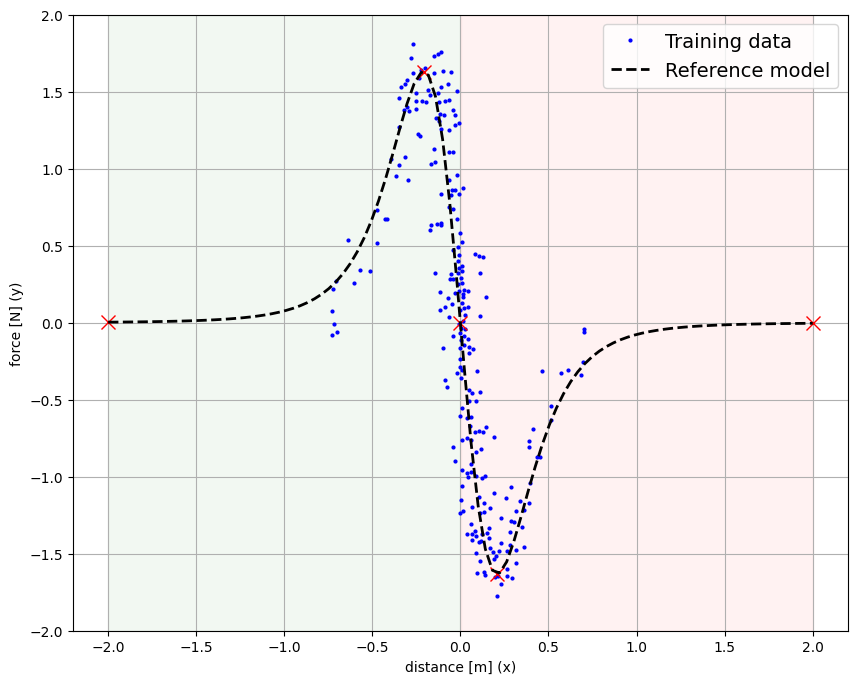

In [2]:
S = dataset.MagmanDatasetScaled()
#S.sample(size=500, noise=0.05, mesh=False)
S.load('data/magman.csv')
#S.erase(-0.3, 0.3)
S.split()  # train_size=0.7 by default
S.plot()

In [3]:
stree, data_tuning_report, knowledge_tuning_report = tree_search.infer_syntaxtree(S, max_degree=6, max_degree_inner=1, max_depth=3, trials=150, kn_pressure=0.8)
print(f"\nData Root found:    {data_tuning_report['root_found']}")
print(f"Data MSE:             {data_tuning_report['mse']}")
print(f"Data R2:              {1 - (data_tuning_report['sse'] / S.data_sst)}")
print(f"Knowledge Root found: {knowledge_tuning_report['root_found']}")
print(f"Knowledge MSE:        {knowledge_tuning_report['mse']}")
if stree is not None: print(f"\nModel: " + stree.tostring())

========== Syntax Tree Inference ==========
TREE FOUND
TREE FOUND
TREE FOUND
TREE FOUND
TREE FOUND

Data tuning (avg time):      0 ms
Knowledge tuning (avg time):   0 ms
Data tuning (total time):      2329 ms
Knowledge tuning (total time): 8519 ms

Get system (avg time): 0 ms
Get system (total time): 10587 ms
Get system (total calls): 46195

Setcoeffs (total time): 58 ms

Data Root found:    False
Data MSE:             0.35571620114381086
Data R2:              0.6603559229031923
Knowledge Root found: False
Knowledge MSE:        0.08301669746918408

Model: P_a(x)/P_b(x)


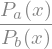

In [4]:
sympy.parse_expr(stree.tostring(), evaluate=False)

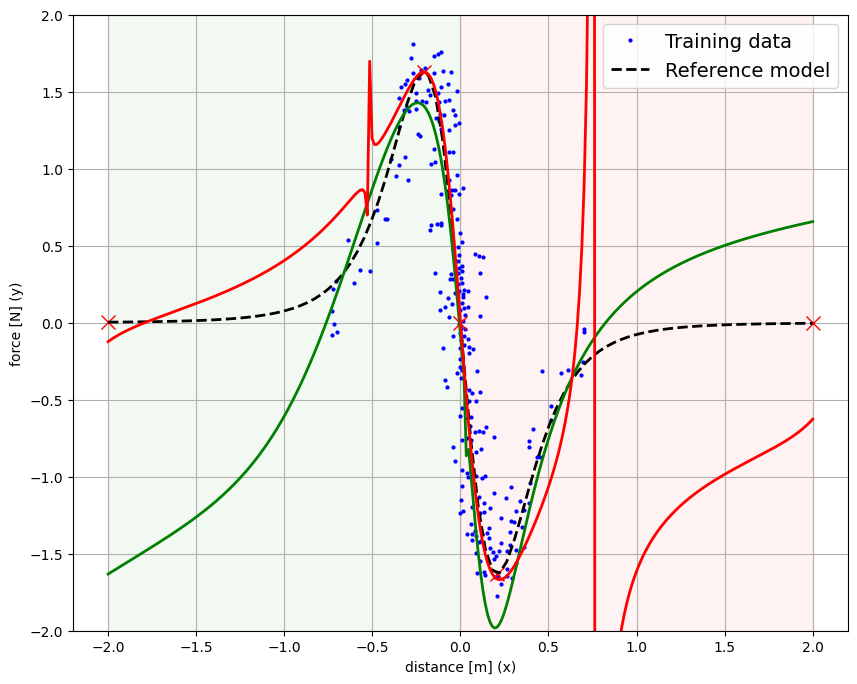

In [14]:
S.plot()

x = np.linspace(S.xl, S.xu, 300)

stree.set_coeffs(data_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='green', label='Data model');

stree.set_coeffs(knowledge_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='red',   label='Knowledge model');

========== Syntax Tree Enhancement ==========
[Restart #1] MSE improvement from None to 0.07896098608643547
[Restart #2] No improvement.
[Restart #3] No improvement.
[Restart #4] No improvement.
[Restart #5] No improvement.
[Restart #6] No improvement.
[Restart #7] No improvement.
[Restart #8] No improvement.
[Restart #9] No improvement.
[Restart #10] No improvement.
Training MSE: 0.07896098608643547


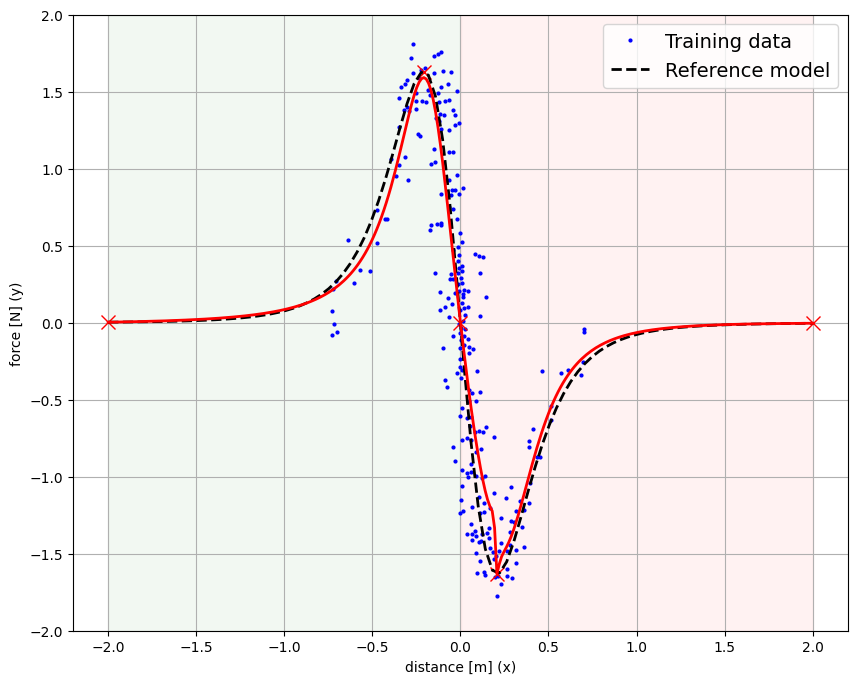

In [10]:
#
# model enhancement
#

sample_size = 10
n_restarts  = 10

best_tuning_report = tree_search.enhance_syntax_tree(stree, S, sample_size, n_restarts)

S.plot()
x = np.linspace(S.xl, S.xu, 300)
stree.set_coeffs(best_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='red', label='Final model');

In [8]:
#
# model testing
#

test_mse, test_r2, pk_sat_ration, pk_sat_count, pk_sat_size = tree_search.test_syntax_tree(stree, S, sample_size=1000)
print(f"Test MSE:       {test_mse}")
print(f"Test R2:        {test_r2}")
print(f"PK sat ratio:   {pk_sat_ration}")
print(f"PK sat count:   {pk_sat_count}")
print(f"PK sat size:    {pk_sat_size}")

========== Syntax Tree Testing ==========
Test MSE:       0.3099633825223376
Test R2:        0.7086049497672823
PK sat ratio:   0.9986019572598362
PK sat count:   5000
PK sat size:    5007
